# ライブラリの準備

In [1]:
import numpy as np
from scipy import stats
import math
from matplotlib import pyplot as plt
from abc import ABCMeta, abstractmethod

# クラスの用意

## 事後分布と事前分布のためのクラス

BetaクラスはPrDクラスを継承する。初期化の際にベータ分布のパラメータa,bを渡す。calPメソッドはxを渡すと${\rm Beta}(x|a,b)$を返す。plotメソッドに文字列をStringで渡すことで${\rm Beta}(x|a,b)$のグラフを$x軸が0から1まで$のグラフとしてプロットする。

In [3]:
# class for prior and posterior
class PrD(metaclass=ABCMeta):
    prd = None
    def __init__(self, prd) -> None:
        self.prd = prd
    @abstractmethod
    def calP(self, theta):
        return self.prd(theta)


class Beta(PrD):
    a = None
    b = None
    prd = None

    def __init__(self, a,b):
        self.a = a
        self.b = b
        def p(theta):
            return stats.beta.pdf(theta, self.a, self.b, loc=0, scale = 1)
        self.prd = p

    def calP(self, theta):
        return super().calP(theta)

    def plot(self, title):
        x = np.arange(0.01, 1,0.01)
        y = self.prd(x)

        plt.plot(x,y)
        plt.title(title)
        plt.xlim(0,1)
        plt.show()

class Dir(PrD):
    alpha = None
    dim = 0
    def __init__(self, alpha):
        self.alpha = alpha
        self.dim = len(alpha)
        def p(pi):
            return stats.dirichlet.pdf(pi, alpha)
        self.prd = p
    def calP(self, pi):
        return super().calP(pi)
    def plot(self, title):
        if self.dim <= 1 or self.dim >= 4:
            return
        elif self.dim == 2:
            
            x1 = np.arange(0.01, 0.99, 0.01)
            x2 = 1-x1
            x = np.stack((x1, x2), axis = 1)
            n = len(x1)
            y = np.empty(n)
            for i in range(n):
                y[i] = self.prd(x[i])

            plt.plot(x1,y)
            plt.title(title)
            plt.xlim(0,1)
            plt.xlabel(r"$\pi _1$")
            plt.show()
        else:
            x1 = np.arange(0.01, 0.99, 0.01)
            x2 = np.arange(0.01, 0.99, 0.01)
            x, y= np.meshgrid(x1, x2)
            x[x + y > 0.99] = 0.01
            y[x + y > 0.99] = 0.01 # 参考:https://cartman0.hatenablog.com/entry/2021/02/27/%E3%83%87%E3%82%A3%E3%83%AA%E3%82%AF%E3%83%AC%28Dirichlet%29%E5%88%86%E5%B8%83%E3%82%923D%E3%81%A7%E5%8F%AF%E8%A6%96%E5%8C%96%E3%81%99%E3%82%8B
            X = x.flatten()
            Y = y.flatten()
            n = len(X)
            Z = np.empty(n)
            for i in range(n):
                Z[i] = self.prd(np.array([X[i], Y[i], 1-X[i]-Y[i]]))
            z = Z.reshape(x.shape)
            ax3d = plt.axes(projection='3d')
            ax3d.plot_surface(x, y, z,cmap='plasma')
            ax3d.set_xlabel(r"$\pi _1$")
            ax3d.set_ylabel(r"$\pi _2$")
            ax3d.set_zlabel(r"Dir($\pi , \alpha$)")
            ax3d.set_title(title)
            plt.show()

class Gam(PrD):
    a = 0.5
    b = 0.5
    def __init__(self, a, b):
        self.a = a
        self.b = b
        def p(lam):
            return stats.gamma.pdf(lam, a,scale=1./b)
        self.prd = p

    def calP(self, lam):
        return super().calP(lam)
    
    def plot(self, title):
        x = np.arange(0.01, 20,0.01)
        y = self.prd(x)

        plt.plot(x,y)
        plt.title(title)
        plt.xlim(0,20)
        plt.show()



## モデルのためのクラス

model_Bernoulliクラスは、model_calPメソッドを使うことで${\rm Bern}(x, theta)$を返す

In [4]:
class Model(metaclass=ABCMeta):
    @abstractmethod
    def model_calP(self, x, theta):
        pass

class model_Bernoulli(Model):
    def model_calP(self, x, theta):
        return stats.bernoulli.pmf(x,theta,loc=0)

class model_Categorical(Model):
    def model_calP(self, s, pi):
        return stats.multinomial.pmf(x=s, n=1, p = pi)

class model_Poisson(Model):
    def model_calP(self, x, lam):
        return stats.poisson.pmf(x, lam)

## 予測分布のためのクラス

In [5]:
class Predictive(metaclass=ABCMeta):
    predictive = None
    @abstractmethod
    def __init__(self, predictive) -> None:
        self.predictive = predictive
    def predict(self, x):
        return self.predictive(x)

class Predictive_Ber(Predictive):
    theta = None
    def __init__(self, theta):
        def predictive(x):
            return stats.bernoulli.pmf(x, theta)
        self.predict = predictive
        self.theta = theta

class Predictive_Cat(Predictive):
    pi = None
    predictive = None
    def __init__(self, pi):
        self.pi = pi
        def predictive(s):
            return stats.multinomial.pmf(x=s, n=1, p = pi)
        self.predictive = predictive
    def predict(self, x):
        return super().predict(x)

class Predictive_NB(Predictive):
    r = 1
    p = 0.5
    def __init__(self, r, p):
        self.r = r
        self.p = p
        def predictive(x):
            return stats.nbinom.pmf(x, r, p)
        self.predictive = predictive
    def predict(self, x):
        return super().predict(x)

## 学習を行うクラスを用意する

BayesianMLクラスはModelクラスとPrDクラスを持つ。trainメソッドを使うことで学習後の同時分布をPrDクラスとして返す。

Ber_BetaクラスはBayesianMLクラスを継承する。初期化の際、ベータ事前分布のパラメータを渡す。trainメソッドを使うことで事後分布と予測分布をタプルとして返す。事後分布はBetaクラス、予測分布は関数として返される。

In [6]:
class BayesianML():
    model = None
    prior = None
    def __init__(self, model, prior):
         self.model = model
         self.prior = prior

    # train self with trainingData and return joint probability distribution
    def train(self, trainingData):

        # define likelihood funciton likelihood_function(theta, trainingData) = P(trainingData| theta)
        def likelihood_function(theta):
            likelihood = 1
            for x in trainingData:
                likelihood = likelihood * self.model.model_calP(x,theta)
            return likelihood

        # define joint function jointPD(theta, trainingData) = P(trainingData, theta)
        def joint_PD(theta):
            return likelihood_function(theta) * self.prior.calP(theta)

        return PrD(joint_PD)

# 返されるのは同時分布ではなく、事後分布
class Ber_Beta(BayesianML):
    a = 0
    b = 0
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.model = model_Bernoulli()
        self.prior = Beta(a, b)
    def train(self, trainingData):
        n = len(trainingData)
        sum = trainingData.sum()
        a_hat = sum + self.a
        b_hat = n - sum + self.b
        pre_theta = a_hat/(a_hat + b_hat)
        return (Beta(a_hat, b_hat), Predictive_Ber(pre_theta))


class Cat_Dir(BayesianML):
    alpha = None
    def __init__(self, alpha):
        self.alpha = alpha
        self.model = model_Categorical()
        self.prior = Dir(alpha)
    
    def train(self, trainingData):
        alpha_hat = np.sum(np.block([[trainingData], [self.alpha]]), axis=0)
        pre_pi = alpha_hat / np.sum(alpha_hat)
        return (Dir(alpha_hat), Predictive_Cat(pre_pi))

class Poi_Gam(BayesianML):
    a = 0.5
    b = 0.5
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.model = model_Poisson()
        self.prior = Gam(a, b)
    
    def train(self, trainingData):
        a_hat = trainingData.sum() + self.a
        b_hat = len(trainingData) + self.b
        return (Gam(a_hat, b_hat), Predictive_NB(a_hat, 1 / (1 + b_hat)))

## 学習を行うための関数を用意する

make_bernoulli_sample(p,N)はパラメータpのベルヌーイ分布から生成された変数をN個np.ndarrayとして返す

learn(bml, trainingSamples, max_N)はbayesianMLクラスをbmlとして受け取り、trainingSamplesについて最大でmax_N個学習を行う。

In [7]:
# make N bernoulli sample with paramater p
def make_bernoulli_sample(p,N, randomState):
    return stats.bernoulli.rvs(p=p, size=N, random_state = randomState)


# make N Categorical sample with paramater pi
def make_categorical_sample(pi, N, randomState):
    return stats.multinomial.rvs(n=1,p=pi, size=N, random_state=randomState)

def make_poisson_sample(lam, N, randomState):
    return stats.poisson.rvs(lam, size=N, random_state=randomState)

# learn max N trainingSamples with CPclass
def learn(bml, trainingSamples, max_N):
    trainingData = trainingSamples[0:max_N]
    return bml.train(trainingData)

def calLoss(predictive, trainingSamples, train_N, testData):
    N = min(len(trainingSamples), train_N)
    tn = -1
    gm = -1
    if N != 0:
        tn = 0
        for x in trainingSamples[0:N]:
            tn = tn + math.log(predictive(x))
        tn = -tn/N
    if len(testData) != 0:
        gm = 0
        for x in testData:
            gm = gm + math.log(predictive(x))
        gm = -gm / len(testData)

    return (tn, gm)

## ベルヌーイ分布についてベータ事前分布を用いて学習を行う

In [8]:
trainingRandomStateBer = 1
testRandomStateBer = 2
trainingSamplesBer = make_bernoulli_sample(0.25, 200, trainingRandomStateBer)
testDataBer = make_bernoulli_sample(0.25, 100, testRandomStateBer)

In [22]:
aBer = 1
bBer = 4
berBeta = Ber_Beta(aBer,bBer)

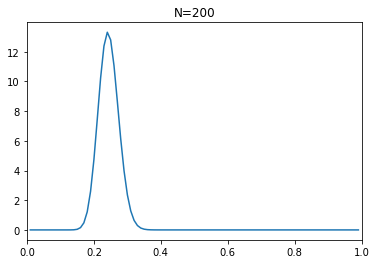

predictive theta = 0.24390243902439024
Tn=0.5567783795344827
Gm=0.48323724228755877


In [25]:
train_NBer = 200
tapleOfBer = learn(berBeta, trainingSamplesBer, train_NBer)
tapleOfBer[0].plot('N='+ str(min(train_NBer, len(trainingSamplesBer))))
lossBer = calLoss(tapleOfBer[1].predict, trainingSamplesBer, train_NBer, testDataBer)
print('predictive theta = ' + str(tapleOfBer[1].theta))
print('Tn='+str(lossBer[0]))
print('Gm='+str(lossBer[1]))

## 2次元のカテゴリ分布

In [11]:
trainingRandomStateCat2 = 1
testRandomStateCat2 = 2
trainingSamplesCat2 = make_categorical_sample(np.array([0.5,0.5]), 200, trainingRandomStateCat2)
testDataCat2 = make_categorical_sample(np.array([0.5,0.5]), 100, testRandomStateCat2)

In [12]:
alphaCat2 = np.array([1,1])
catDir2d = Cat_Dir(alphaCat2)

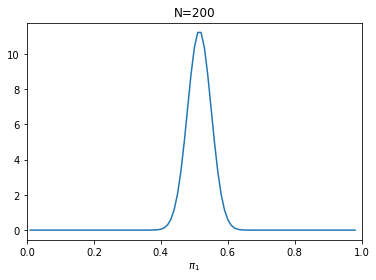

predictive pi = [0.51485149 0.48514851]
Tn=0.6926971571881703
Gm=0.6971539137234817


In [28]:
train_NCat2 = 200
tapleOfCat2 = learn(catDir2d, trainingSamplesCat2, train_NCat2)
tapleOfCat2[0].plot('N=' + str(train_NCat2))
lossCat2 = calLoss(tapleOfCat2[1].predict, trainingSamplesCat2, train_NCat2, testDataCat2)
print('predictive pi = ' + str(tapleOfCat2[1].pi))
print('Tn='+str(lossCat2[0]))
print('Gm='+str(lossCat2[1]))

## 3次元のカテゴリ分布

In [14]:
trainingRandomStateCat3 = 1
testRandomStateCat3 = 2
trainingSamplesCat3 = make_categorical_sample(np.array([0.2,0.3,0.5]), 200, trainingRandomStateCat3)
testDataCat3 = make_categorical_sample(np.array([0.2,0.3,0.5]), 100, testRandomStateCat3)

In [15]:
alphaCat3 = np.array([1,1,1])
catDir3d = Cat_Dir(alphaCat3)

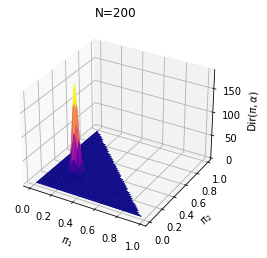

predictive pi = [0.19211823 0.33004926 0.47783251]
Tn=1.0337194321965113
Gm=0.9588384281569783


In [32]:
train_NCat3 = 200
tapleOfCat3 = learn(catDir3d, trainingSamplesCat3, train_NCat3)
tapleOfCat3[0].plot('N=' + str(train_NCat3))
lossCat3 = calLoss(tapleOfCat3[1].predict, trainingSamplesCat3, train_NCat3, testDataCat3)
print('predictive pi = ' + str(tapleOfCat3[1].pi))
print('Tn='+str(lossCat3[0]))
print('Gm='+str(lossCat3[1]))

## ポアソン分布

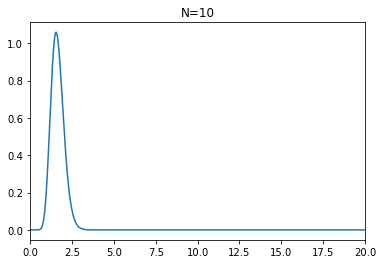

Tn=40.64403055611978
Gm=40.21302501719467


In [34]:
trainingRandomStatePoi = 1
testRandomStatePoi = 2
trainingSamplesPoi = make_poisson_sample(2, 200, trainingRandomStatePoi)
testDataPoi = make_poisson_sample(2, 100, testRandomStatePoi)
aPoi = 1
bPoi = 1
poiGam = Poi_Gam(aPoi, bPoi)
train_NPoi = 10
tapleOfPoi = learn(poiGam, trainingSamplesPoi, train_NPoi)
tapleOfPoi[0].plot('N=' + str(train_NPoi))
lossPoi = calLoss(tapleOfPoi[1].predict, trainingSamplesPoi, train_NPoi, testDataPoi) # データを増やした場合計算できなくなることがある。
print('Tn='+str(lossPoi[0]))
print('Gm='+str(lossPoi[1])) # データを増やすと損失が大きくなる